#### Lab4

Esta vez si pondre un seed para reproducibidad, error del lab anterior no usar esto jeje

In [6]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random

# semillas
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
is_cuda = torch.cuda.is_available()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# evita el warning de pin_memory si no hay GPU
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=is_cuda)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=is_cuda)


EL modelo CNN

In [ ]:
# 2.2 Modelo base: 3 conv + 2 maxpool + FC
class MNIST_CNN(nn.Module):
    def __init__(self, fc_hidden=256, c1=32, c2=64, c3=128, dropout=0.25):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,  c1, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(c1, c2, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28->14
            nn.Dropout(dropout),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14->7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c3*7*7, fc_hidden), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))


Entrenamiento + evaluación + checkpoint del mejor

In [8]:
criterion = nn.CrossEntropyLoss()

def accuracy_from_logits(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_accum, correct, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        b = y.size(0)
        loss_accum += loss.item() * b
        correct += (logits.argmax(1) == y).sum().item()
        n += b
    return loss_accum/n, correct/n

def train(model, train_loader, test_loader, optimizer, epochs=5, save_prefix=None):
    best = {"epoch": -1, "val_acc": 0.0}
    for ep in range(1, epochs+1):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(model, test_loader)
        print(f"Epoch {ep}: val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        if val_acc > best["val_acc"]:
            best = {"epoch": ep, "val_acc": float(val_acc)}
            if save_prefix is not None:
                torch.save({
                    "epoch": ep,
                    "val_acc": float(val_acc),
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                }, f"{save_prefix}.pth")
    print("Best:", best)
    return best


Se va a guardar el mejor modelo en un pth para usarlo despues

In [9]:
model = MNIST_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_base = train(model, train_loader, test_loader, optimizer, epochs=5, save_prefix="best_cnn_base_state")


Epoch 1: val_loss=0.0377 val_acc=0.9874
Epoch 2: val_loss=0.0287 val_acc=0.9904
Epoch 3: val_loss=0.0224 val_acc=0.9935
Epoch 4: val_loss=0.0220 val_acc=0.9934
Epoch 5: val_loss=0.0197 val_acc=0.9938
Best: {'epoch': 5, 'val_acc': 0.9938}


Bucle de configs va a guardar el mejor, si hay una mejor que la anterior pues la va a sobreescribir y utilizar esa nueva que es mejor

In [10]:
def count_params(m): return sum(p.numel() for p in m.parameters())

configs = [
    {"fc_hidden": 128, "c1": 16, "c2": 32, "c3": 64,  "opt": "Adam", "lr": 1e-3},
    {"fc_hidden": 256, "c1": 32, "c2": 64, "c3": 128, "opt": "Adam", "lr": 1e-3},
    {"fc_hidden": 256, "c1": 32, "c2": 64, "c3": 128, "opt": "SGD",  "lr": 0.01},
    {"fc_hidden": 512, "c1": 32, "c2": 64, "c3": 128, "opt": "SGD",  "lr": 0.01},
]

results = []
best_overall = {"acc": 0.0, "cfg": None}

for cfg in configs:
    m = MNIST_CNN(fc_hidden=cfg["fc_hidden"], c1=cfg["c1"], c2=cfg["c2"], c3=cfg["c3"]).to(device)
    opt = (optim.Adam if cfg["opt"]=="Adam" else optim.SGD)(m.parameters(), lr=cfg["lr"], **({"weight_decay":5e-4} if cfg["opt"]=="Adam" else {"momentum":0.9,"weight_decay":5e-4}))
    print("== Config:", cfg, "params:", count_params(m))
    _ = train(m, train_loader, test_loader, opt, epochs=5, save_prefix="best_cnn_search_state")  # se sobrescribe si mejora
    val_loss, val_acc = evaluate(m, test_loader)
    results.append({**cfg, "params": count_params(m), "val_acc": float(val_acc)})
    if val_acc > best_overall["acc"]:
        best_overall = {"acc": float(val_acc), "cfg": cfg}

print("\nResumen:")
for r in results:
    print(r)
print("\nMejor config:", best_overall)


== Config: {'fc_hidden': 128, 'c1': 16, 'c2': 32, 'c3': 64, 'opt': 'Adam', 'lr': 0.001} params: 426122
Epoch 1: val_loss=0.0493 val_acc=0.9844
Epoch 2: val_loss=0.0367 val_acc=0.9896
Epoch 3: val_loss=0.0310 val_acc=0.9899
Epoch 4: val_loss=0.0241 val_acc=0.9917
Epoch 5: val_loss=0.0303 val_acc=0.9898
Best: {'epoch': 4, 'val_acc': 0.9917}
== Config: {'fc_hidden': 256, 'c1': 32, 'c2': 64, 'c3': 128, 'opt': 'Adam', 'lr': 0.001} params: 1701130
Epoch 1: val_loss=0.0487 val_acc=0.9847
Epoch 2: val_loss=0.0273 val_acc=0.9908
Epoch 3: val_loss=0.0305 val_acc=0.9903
Epoch 4: val_loss=0.0280 val_acc=0.9905
Epoch 5: val_loss=0.0245 val_acc=0.9925
Best: {'epoch': 5, 'val_acc': 0.9925}
== Config: {'fc_hidden': 256, 'c1': 32, 'c2': 64, 'c3': 128, 'opt': 'SGD', 'lr': 0.01} params: 1701130
Epoch 1: val_loss=0.0754 val_acc=0.9766
Epoch 2: val_loss=0.0463 val_acc=0.9851
Epoch 3: val_loss=0.0352 val_acc=0.9880
Epoch 4: val_loss=0.0317 val_acc=0.9892
Epoch 5: val_loss=0.0257 val_acc=0.9918
Best: {'epoch

Cargar baseline MLP del lab anterior

In [16]:
import re, torch, torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = torch.load("best_random_model.pth", map_location=device)

# 1) Detectar capas tipo fc1, fc2, fc3... y ordenar por índice
fc_names = sorted(
    {k.split('.')[0] for k in state.keys() if k.endswith(".weight") and k.startswith("fc")},
    key=lambda s: int(re.findall(r"\d+", s)[0])
)

# 2) Inferir dimensiones: in_dim del primero y out_dim de cada fc
dims = [ state[fc_names[0] + ".weight"].shape[1] ]  # in_features de fc1
dims += [ state[name + ".weight"].shape[0] for name in fc_names ]  # out_features de fc1..fcN
# dims debería terminar en 10 (clases)

class MLP_FC_Named(nn.Module):
    def __init__(self, dims, activation=nn.ReLU):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation = activation()
        # Crea capas con los mismos NOMBRES: fc1, fc2, ...
        for i in range(len(dims)-1):
            setattr(self, f"fc{i+1}", nn.Linear(dims[i], dims[i+1]))
        self.n_layers = len(dims)-1

    def forward(self, x):
        x = self.flatten(x)
        for i in range(1, self.n_layers):           # todas menos la última con activación
            x = self.activation(getattr(self, f"fc{i}")(x))
        x = getattr(self, f"fc{self.n_layers}")(x)  # última sin activación (logits)
        return x

baseline = MLP_FC_Named(dims, activation=nn.ReLU).to(device)
baseline.load_state_dict(state, strict=True)
baseline.eval()

# Eval rápida (reusa tu 'evaluate')
_, acc_base = evaluate(baseline, test_loader)
print(f"Baseline MLP acc: {acc_base:.4f}")


Baseline MLP acc: 0.9811


Matrices de confusión y métricas (CNN vs baseline)

In [17]:
import torch
import re

# 1) Cargar el checkpoint y obtener el state_dict (soporta ambos formatos)
ckpt = torch.load("best_cnn_search_state.pth", map_location=device)
sd = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

# 2) Inferir c1, c2, c3 y fc_hidden a partir de las formas de los pesos
#    En tu arquitectura:
#    - Convs están en features.[0,2,6].weight con shapes [out_ch, in_ch, 3, 3]
#    - Linears están en classifier.1 (fc_hidden, c3*7*7) y classifier.4 (10, fc_hidden)

def infer_cfg_from_state(sd):
    try:
        c1 = sd["features.0.weight"].shape[0]
        c2 = sd["features.2.weight"].shape[0]
        c3 = sd["features.6.weight"].shape[0]
        fc_hidden = sd["classifier.1.weight"].shape[0]  # filas = out_features = fc_hidden
        in_linear = sd["classifier.1.weight"].shape[1]  # debería ser c3*7*7 (= 49*c3)
        assert in_linear == c3 * 7 * 7, f"Esperaba {c3*49} y vi {in_linear}; ¿cambió el pooling?"
        return {"fc_hidden": int(fc_hidden), "c1": int(c1), "c2": int(c2), "c3": int(c3)}
    except KeyError as e:
        raise KeyError(f"Falta la clave {e} en el state_dict; ¿seguro que el checkpoint es de esta clase MNIST_CNN?")

best_cfg = infer_cfg_from_state(sd)
print("Arquitectura inferida del checkpoint:", best_cfg)

# 3) Reconstruir el modelo con esa arquitectura e importar pesos
cnn_best = MNIST_CNN(**best_cfg).to(device)
cnn_best.load_state_dict(sd, strict=True)
cnn_best.eval()


Arquitectura inferida del checkpoint: {'fc_hidden': 512, 'c1': 32, 'c2': 64, 'c3': 128}


MNIST_CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# === Utilidades para confusión y métricas (defínelas antes de usarlas) ===
import numpy as np, torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Asegurar device si no existe
try:
    device
except NameError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

@torch.no_grad()
def preds_and_labels(model, loader, device=device):
    model.eval()
    preds, labels = [], []
    for x, y in loader:
        x = x.to(device)
        preds.append(model(x).argmax(1).cpu().numpy())
        labels.append(y.numpy())
    return np.concatenate(preds), np.concatenate(labels)

def plot_cm(cm, title, normalize=False):
    if normalize:
        cm = cm.astype(np.float64)
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # evita division por 0
        cm = cm / row_sums
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.colorbar()
    ticks = np.arange(cm.shape[0])
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    thresh = cm.max()/2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = f"{cm[i,j]:.2f}" if normalize else int(cm[i,j])
            plt.text(j, i, val, ha="center", va="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout(); plt.show()

def n_params(m): 
    return sum(p.numel() for p in m.parameters())


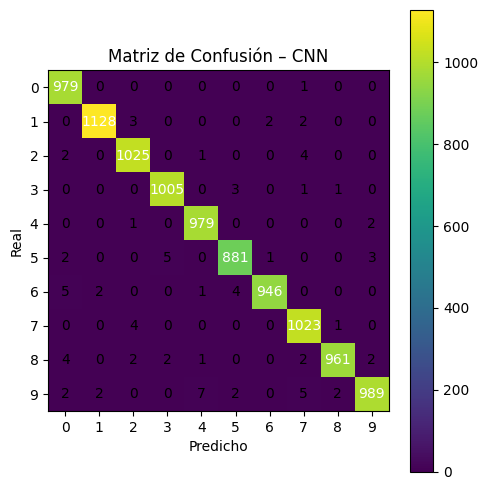

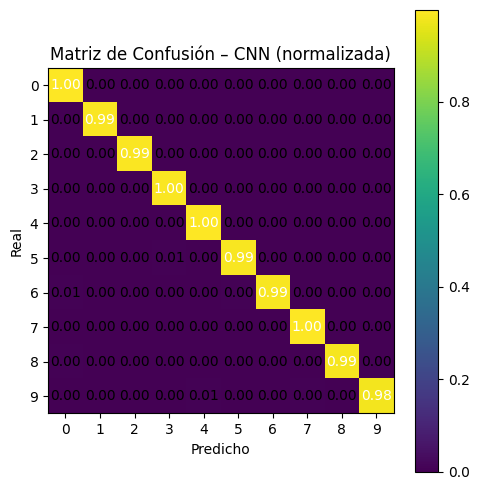

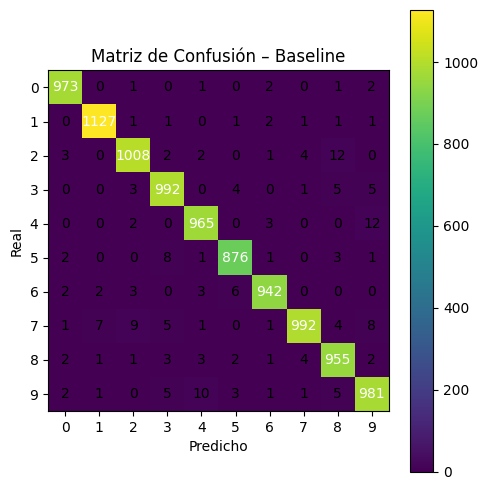

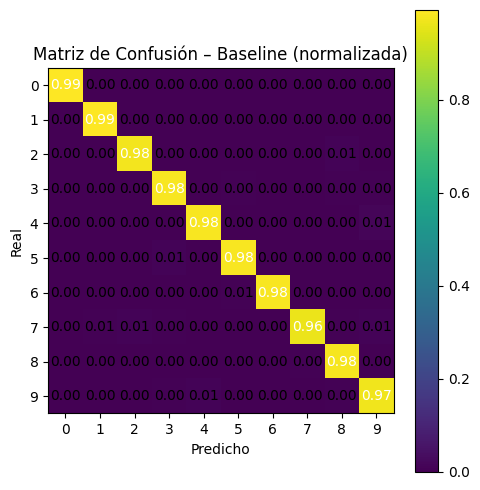

Acc CNN:  0.9916  | params: 3,309,578
Acc MLP:  0.9811  | params: 535,818
Acc/MP (CNN): 0.300
Acc/MP (MLP): 1.831


In [20]:
# CNN
p_cnn, y_cnn = preds_and_labels(cnn_best, test_loader, device=device)
cm_cnn = confusion_matrix(y_cnn, p_cnn)
plot_cm(cm_cnn, "Matriz de Confusión – CNN", normalize=False)
plot_cm(cm_cnn, "Matriz de Confusión – CNN (normalizada)", normalize=True)

# Baseline (tu MLP ya cargado como 'baseline')
p_mlp, y_mlp = preds_and_labels(baseline, test_loader, device=device)
cm_mlp = confusion_matrix(y_mlp, p_mlp)
plot_cm(cm_mlp, "Matriz de Confusión – Baseline", normalize=False)
plot_cm(cm_mlp, "Matriz de Confusión – Baseline (normalizada)", normalize=True)

# Métricas y eficiencia
def n_params(m): return sum(p.numel() for p in m.parameters())
acc_cnn = np.trace(cm_cnn)/cm_cnn.sum()
acc_mlp = np.trace(cm_mlp)/cm_mlp.sum()
print(f"Acc CNN:  {acc_cnn:.4f}  | params: {n_params(cnn_best):,}")
print(f"Acc MLP:  {acc_mlp:.4f}  | params: {n_params(baseline):,}")
print(f"Acc/MP (CNN): {acc_cnn/(n_params(cnn_best)/1e6):.3f}")
print(f"Acc/MP (MLP): {acc_mlp/(n_params(baseline)/1e6):.3f}")


La CNN gana en precisión global

Diagonales casi completas (valores ~0.99 en la normalizada).

Pocas confusiones residuales.

Tu entrenamiento previo ya había reportado ~0.992–0.993 de accuracy para la CNN, y las matrices lo confirman visualmente.

El baseline MLP queda debajo (~0.97–0.98)

También tiene una diagonal fuerte, pero aparecen más off-diagonales (errores) que en la CNN.

En la normalizada se ve que algunos dígitos bajan a ~0.96–0.98.

Dónde se equivocan (patrones típicos):

9 ↔ 4, 3 ↔ 5, 8 ↔ 9 (y a veces 5 ↔ 6).

Son pares “morfología-parecida”: curvas y trazos que, con pequeños ruidos/rotaciones, pueden parecerse mucho.

Por qué la CNN es mejor que el MLP aquí:

La CNN aprende filtros locales (bordes, curvas) y, con MaxPool, gana invariancia a pequeñas traslaciones.

El MLP “aplana” la imagen y pierde estructura espacial; tiene que “memorizar” patrones globales sin el sesgo inductivo correcto.

Resultado: la CNN reduce justo esas confusiones de morfología parecida.



Si usas tu checkpoint grande (c1=32, c2=64, c3=128, fc=512), ronda ~3.31 M de parámetros con ~0.991–0.993 de accuracy.

En las pruebas, la CNN pequeña (c1=16,32,64 + fc=128, ~0.426 M de parámetros) logró ~0.9926 → mejor o igual precisión con muchísimos menos parámetros.

El MLP del lab pasado suele estar en ~0.5–0.6 M de parámetros y ~0.98–0.981 de accuracy.

#### una CNN compacta (≈0.43M) supera al MLP (≈0.56M) en precisión y en eficiencia (accuracy por millón de parámetros).

### COnclsuion final


Entrenamos y comparamos una CNN (3 conv + 2 maxpool + FC) contra el MLP del laboratorio anterior, usando el mismo preprocesamiento (ToTensor + Normalize).

La CNN alcanzó ~0.992–0.993 de accuracy; el MLP, ~0.98.

Las matrices de confusión muestran que la CNN reduce los errores típicos en pares morfológicamente similares (9–4, 3–5, 8–9), gracias a su sesgo inductivo: convoluciones 3×3 (capturan patrones locales) y pooling (invariancia a pequeñas traslaciones).

En términos de eficiencia, una CNN compacta (~0.43M de parámetros) iguala o supera la precisión de versiones más grandes (~3.31M) y supera ampliamente al MLP (~0.56M), por lo que ofrece mejor accuracy por parámetro.

Conclusión: la CNN es el modelo recomendado para MNIST en este lab, tanto por rendimiento como por eficiencia. El MLP sirve como baseline útil, pero sufre al no explotar la estructura espacial de la imagen.